# Fitting a drift diffusion model to SET data

## TODOs & thoughs
* Include within-subjects effects using patsy package -> http://ski.clps.brown.edu/hddm_docs/tutorial_python.html#within-subject-effects
* Integrate pupil pattern (lin, quad, lin-quad) as predictor in regression -> http://ski.clps.brown.edu/hddm_docs/tutorial_python.html#fitting-regression-models
* Better explanation of regression (just do `m = hddm.models.HDDMRegressor(data, 'v ~ BOLD')`) -> http://ski.clps.brown.edu/hddm_docs/howto.html#estimate-a-regression-model

## Problems and solutions
* `ValueError: Buffer dtype mismatch, expected 'double' but got 'long'` -> rts must be coded in seconds (not miliseconds)
* `KeyError: 'rt'` -> column names must match up with example here: http://ski.clps.brown.edu/hddm_docs/tutorial_python.html
* `ZeroProbability: Stochastic wfpt(0span).8.0's value is outside its support, or it forbids its parents' current values.` -> remove all subjects for which it throws this error
* `Could not generate output statistics for a_subj(1span).12.0` -> number of samples must greater than number of burn. e.g., model.sample(300, burn=300) does NOT work, but model.sample(500, burn=300) works!
* `AssertionError: Step-out procedure failed` -> increase number of samples

## Explanation of HDDM parameters
see also http://ski.clps.brown.edu/hddm_docs/methods.html

* v -> The speed with which the accumulation process approaches one of the two boundaries is called drift-rate v and represents the relative evidence for or against a particular response.
* a -> The distance between the two boundaries (i.e. threshold a) influences how much evidence must be accumulated until a response is executed. 
* t -> Response time, however, is not solely comprised of the decision making process – perception, movement initiation and execution all take time and are lumped in the DDM by a single non-decision time parameter t.
* z -> The model also allows for a prepotent bias z affecting the starting point of the drift process relative to the two boundaries.
* sv-> inter-trial variability in drift-rate
* st -> inter-trial variability in non-decision time
* sz -> inter-trial variability in starting-point

## Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import hddm
import glob
import numpy as np
from first import first

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [7]:
file_dir = "C:/Users/maria/MEGAsync/Berkeley/R scripts/sequentialset/subj_files/databoth/raw_data"
n_subj = 61  # there are 61 in total
preprocess_data = True
run_acc_model = True
run_stim_model = True
n_burn = 1000  # traces look good after about 1000
n_sample = 1000 + n_burn  # n_samples must be > n_burn

In [8]:
# Read in and clean data
if preprocess_data:
    files = glob.glob(file_dir + "/seq*SET*.csv")[:n_subj]
    all_data = pd.DataFrame()

    for file in files:

        # Drop unncessary rows and columns
        data_file = pd.read_csv(file, low_memory=False)
        data_file = data_file[data_file.TrainorExp == "Train"]
        data_file = data_file[["Subject", "TrialId", "CRESP", "RESP", "ACC", "RT", "Category", "SETornoSET"]]

        # Add all subjects into one file
        all_data = all_data.append(data_file)

    # Remove eye tracking data
    grouped = all_data.groupby(["Subject", "TrialId"], as_index=False)
    all_data = grouped.agg(first)

    all_data['RT'] = all_data['RT'] / 1000
    all_data = all_data.rename(columns={"Subject": "subj_idx", "RT": "rt"})

    all_data.to_csv("hddm/hddm_all_data.csv")
    
else:
    all_data = pd.read_csv("hddm/hddm_all_data.csv")
    
exclude = [8, 19, 33, 303, 309, 320]
all_data = all_data[np.logical_not(all_data.subj_idx.isin(exclude))]
all_data.describe()

,subj_idx,TrialId,ACC,rt
count,660.000000,660.000000,546.0,658.000000
mean,139.763636,7.500000,1.0,0.849799
std,145.031456,3.454671,0.0,0.886113
min,3.000000,2.000000,1.0,0.005000
25%,18.000000,4.750000,1.0,0.404000
50%,35.000000,7.500000,1.0,0.612000
75%,314.000000,10.250000,1.0,0.976250
max,330.000000,13.000000,1.0,9.903000


## Accuracy model

In [9]:
# Reshape data for ACCURACY MODEL
acc_data = all_data.copy()
acc_data = acc_data.rename(columns={"ACC": "response"})
acc_data.head()

,subj_idx,TrialId,CRESP,RESP,response,rt,Category,SETornoSET
0,3.0,2.0,p,p,1.0,1.405,1span,a SET
1,3.0,3.0,q,q,1.0,0.598,1span,not a SET
2,3.0,4.0,p,p,1.0,0.850,0span,a SET
3,3.0,5.0,p,q,NaN,0.514,2span,a SET
4,3.0,6.0,q,q,1.0,0.929,0span,not a SET


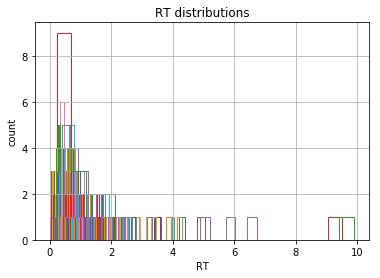

In [12]:
# Plot RT distributions
acc_data = hddm.utils.flip_errors(acc_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in acc_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
plt.savefig('hddm/rt_hist.pdf')

In [11]:
# Create basic accuracy model
if run_acc_model:
    acc_model = hddm.HDDM(acc_data,
                          depends_on={'a': 'Category', 'v': 'Category'},
                          p_outlier=0.05)
    acc_model.find_starting_values()
    acc_model.sample(n_sample, burn=n_burn)
    acc_traces = acc_model.get_traces()
    acc_traces.to_csv("hddm/acc_traces.csv")

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:2573: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:2582: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


AssertionError: Step-out procedure failed

In [ ]:
# Create more advanced accuracy model
if run_acc_model:
    acc_model = hddm.HDDM(acc_data,
                          depends_on={'a': 'Category', 'v': 'Category'},
                          include=('z', 'sv', 'st', 'sz'),
                          p_outlier=0.05)
    acc_model.find_starting_values()
    acc_model.sample(n_sample, burn=n_burn)
    acc_traces = acc_model.get_traces()
    acc_traces.to_csv("hddm/acc_traces_complete.csv")

In [ ]:
acc_model.plot_posteriors(['a', 't', 'v', 'a_std'])
plt.savefig('hddm/acc_posteriors.pdf')

In [ ]:
# models = []
# for i in range(5):
#     m = hddm.HDDM(data)
#     m.find_starting_values()
#     m.sample(5000, burn=20)
#     models.append(m)

# hddm.analyze.gelman_rubin(models)

In [ ]:
stats = acc_model.gen_stats()
stats.to_csv('acc_stats.csv')

In [ ]:
a0, a1, a2, a3 = acc_model.nodes_db.node[['a(0span)', 'a(1span)', 'a(2span)', 'a(3span)']]
hddm.analyze.plot_posterior_nodes([a0, a1, a2, a3])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')
plt.savefig('hddm/acc_posterior_nodes_a.pdf')

In [ ]:
v0, v1, v2, v3 = acc_model.nodes_db.node[['v(0span)', 'v(1span)', 'v(2span)', 'v(3span)']]
hddm.analyze.plot_posterior_nodes([v0, v1, v2, v3])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')
plt.savefig('hddm/acc_posterior_nodes_v.pdf')

In [ ]:
acc_model.plot_posterior_predictive(figsize=(14, 10))
plt.savefig('hddm/acc_posterior_predictive.pdf')

## Stimulus model

In [ ]:
# Bring data in correct shape for STIMULUS CODING MODEL
# In that case, the ‘resp’ column in your data should contain 0 and 1 for the chosen stimulus (or direction),
# not whether the response was correct or not as you would use in accuracy coding.
# You then have to provide another column (referred to as stim_col) which contains information about which the correct response was.
stim_data = all_data.copy()
stim_data = stim_data.rename(columns={"RESP": "response", "CRESP": "correct_response"})
stim_data = stim_data.replace({'response': {'p': 1, 'q': 0}})
stim_data = stim_data.replace({'correct_response': {'p': 1, 'q': 0}})
stim_data.head()

In [ ]:
# Plot RT distributions
stim_data = hddm.utils.flip_errors(stim_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in stim_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [ ]:
if run_stim_model:
    # Run hddm on SET vs noSET responses
    stim_model = hddm.HDDMStimCoding(stim_data,
                                     split_param='v',
                                     stim_col='correct_response',
                                     depends_on={'a': 'Category', 'v': 'Category'},
                                     p_outlier=0.05)
    stim_model.find_starting_values()
    stim_model.sample(n_samples, burn=n_burn)
    stim_traces = stim_model.get_traces()
    stim_traces.to_csv('hddm/stim_traces.csv')

In [ ]:
a0, a1, a2, a3 = stim_model.nodes_db.node[['a(0span)', 'a(1span)', 'a(2span)', 'a(3span)']]
hddm.analyze.plot_posterior_nodes([a0, a1, a2, a3])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')
plt.savefig('hddm/stim_posterior_nodes_a.pdf')

In [ ]:
v0, v1, v2, v3 = stim_model.nodes_db.node[['v(0span)', 'v(1span)', 'v(2span)', 'v(3span)']]
hddm.analyze.plot_posterior_nodes([v0, v1, v2, v3])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')
plt.savefig('hddm/stim_posterior_nodes_v.pdf')